In [17]:
pip install medmnist torch torchvision matplotlib seaborn scikit-learn umap-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd

# Load the npz file directly
data = np.load('pathmnist.npz')

# Combine all splits
all_images = np.concatenate([
    data['train_images'],
    data['val_images'],
    data['test_images']
], axis=0)

all_labels = np.concatenate([
    data['train_labels'],
    data['val_labels'],
    data['test_labels']
], axis=0).flatten()

# Flatten each image from (28, 28, 3) → 1D vector
flat_images = all_images.reshape((all_images.shape[0], -1))

# Create DataFrame: first column is label, rest are pixels
df_full = pd.DataFrame(flat_images)
df_full.insert(0, "label", all_labels)

# Preview
print(df_full.head())

# Optional: Save to CSV
df_full.to_csv("pathmnist_full_dataset.csv", index=False)

   label      0      1      2      3      4      5      6      7      8  ...  \
0    0.0  220.0  208.0  227.0  219.0  207.0  227.0  220.0  207.0  227.0  ...   
1    4.0  126.0   59.0  119.0  142.0   84.0  139.0  174.0  127.0  176.0  ...   
2    7.0  223.0  168.0  204.0  223.0  166.0  203.0  218.0  170.0  205.0  ...   
3    5.0  216.0  135.0  183.0  216.0  127.0  178.0  213.0  125.0  175.0  ...   
4    5.0  204.0  124.0  177.0  204.0  116.0  170.0  211.0  149.0  190.0  ...   

    2342   2343   2344   2345   2346   2347   2348   2349   2350   2351  
0  227.0  220.0  208.0  227.0  221.0  208.0  227.0  222.0  209.0  228.0  
1  211.0  185.0  150.0  193.0  168.0  126.0  177.0  177.0  137.0  184.0  
2  178.0  220.0  163.0  200.0  223.0  159.0  199.0  223.0  155.0  196.0  
3  188.0  212.0  130.0  178.0  214.0  129.0  178.0  218.0  133.0  181.0  
4  180.0  194.0  124.0  176.0  217.0  170.0  205.0  229.0  206.0  225.0  

[5 rows x 2353 columns]


In [ ]:
# Step 1: Define the mapping from label numbers to medical class names
label_map = {
    0: 'ADI',
    1: 'BACK',
    2: 'DEB',
    3: 'LYM',
    4: 'MUC',
    5: 'MUS',
    6: 'NORM',
    7: 'STR',
    8: 'TUM'
}

# Step 2: Apply stratified sampling (4500 rows per class)
df_sampled = df_full.groupby('label').apply(lambda x: x.sample(n=4500, random_state=42)).reset_index(drop=True)

# Step 3: Replace numeric labels with string labels using the mapping
df_sampled['label'] = df_sampled['label'].map(label_map)

# Save to CSV
df_sampled.to_csv("pathmnist_stratified_4500_per_class_labeled.csv", index=False)

# Confirm shape
print(df_sampled.shape)

/var/folders/sy/hms76h_s3393m0hc_w8sjrvh0000gn/T/ipykernel_45500/31134318.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_full.groupby('label').apply(lambda x: x.sample(n=4500, random_state=42)).reset_index(drop=True)


(40500, 2353)


In [ ]:
# Step 4: Check and drop missing values
missing_before = df_sampled.isnull().sum().sum()
df_sampled = df_sampled.dropna()
missing_after = df_sampled.isnull().sum().sum()

# Step 5: Check and drop duplicate rows
duplicates_before = df_sampled.duplicated().sum()
df_sampled = df_sampled.drop_duplicates()
duplicates_after = df_sampled.duplicated().sum()

# Save cleaned dataset again
df_sampled.to_csv("pathmnist_balanced_labeled_cleaned.csv", index=False)

# Print summary
print(f"Missing values removed: {missing_before - missing_after}")
print(f"Duplicate rows removed: {duplicates_before - duplicates_after}")
print(f"Final shape: {df_sampled.shape}")


Missing values removed: 0
Duplicate rows removed: 0
Final shape: (40500, 2353)


In [ ]:
# Step 6: One-hot encode the label column and keep the original label
if 'label' in df_sampled.columns:
    df_encoded = pd.get_dummies(df_sampled, columns=['label'])
    df_encoded['label'] = df_sampled['label']  # reattach the original label
else:
    print("Error: 'label' column not found in df_sampled.")

# Save the final one-hot encoded dataset
df_encoded.to_csv("pathmnist_preprocessed_final.csv", index=False)

# Confirmation message
print(f"\n✅ Final one-hot encoded dataset saved as 'pathmnist_preprocessed_final.csv'.")
print(f"Final DataFrame shape: {df_encoded.shape}")


✅ Final one-hot encoded dataset saved as 'pathmnist_preprocessed_final.csv'.
Final DataFrame shape: (40500, 2362)


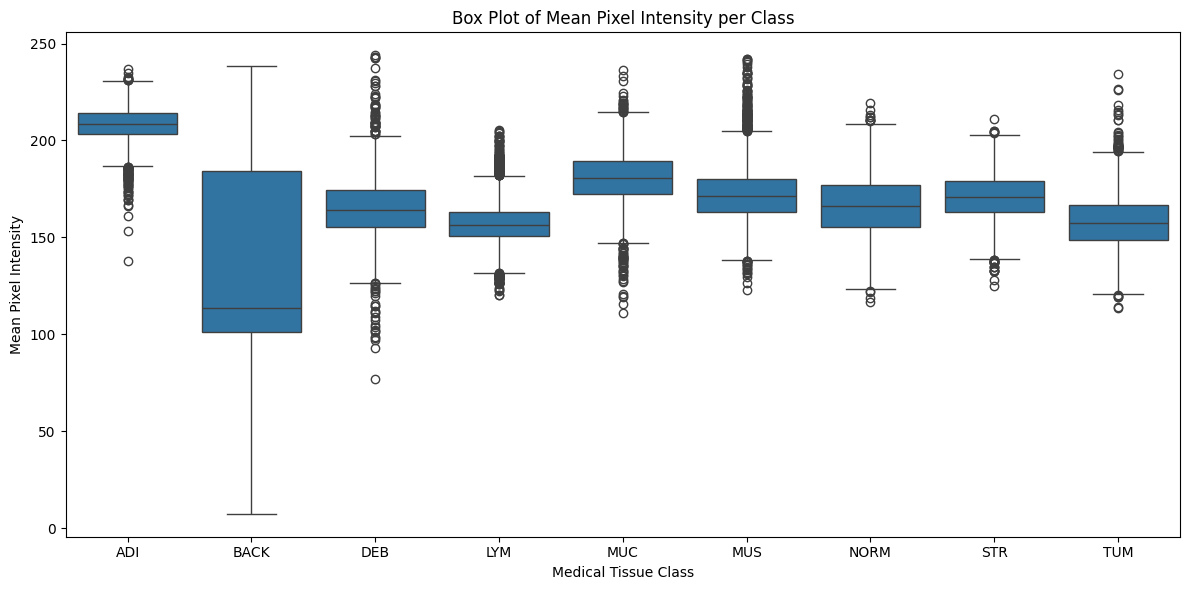

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean intensity from all pixel columns
pixel_columns = df_sampled.columns.difference(['label'])
df_sampled['MeanIntensity'] = df_sampled[pixel_columns].mean(axis=1)

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='MeanIntensity', data=df_sampled)
plt.title("Box Plot of Mean Pixel Intensity per Class")
plt.xlabel("Medical Tissue Class")
plt.ylabel("Mean Pixel Intensity")
plt.tight_layout()
plt.show()

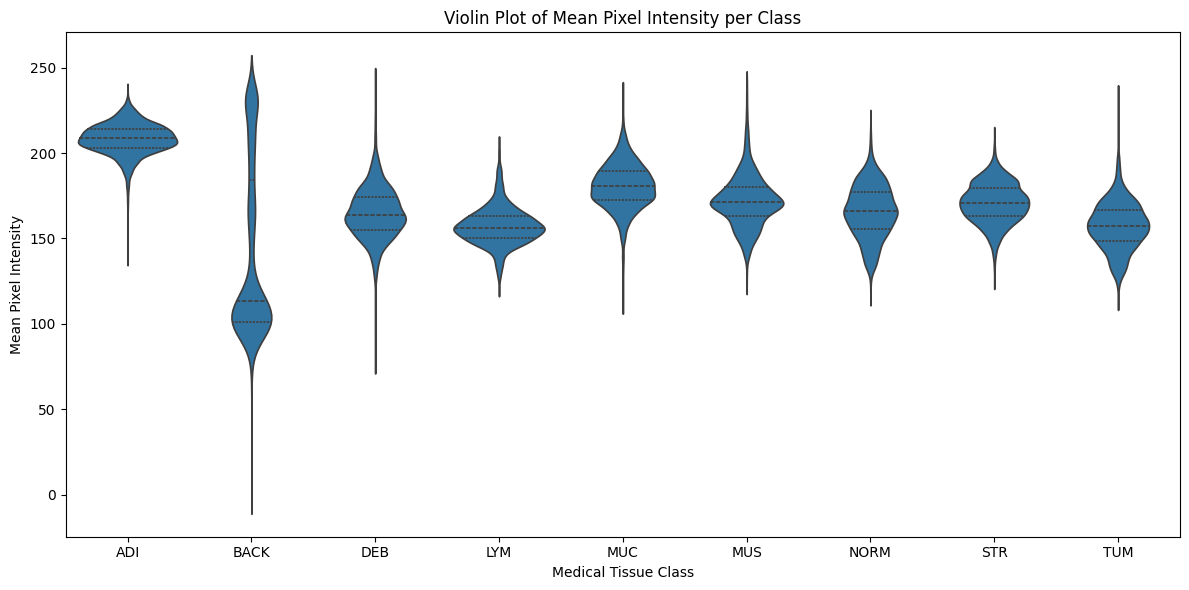

In [11]:
# Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='label', y='MeanIntensity', data=df_sampled, inner='quartile')
plt.title("Violin Plot of Mean Pixel Intensity per Class")
plt.xlabel("Medical Tissue Class")
plt.ylabel("Mean Pixel Intensity")
plt.tight_layout()
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

# X = pixel values only, y = label
X = df_sampled.drop(columns=['label', 'MeanIntensity'], errors='ignore')
y = df_sampled['label']

# First split: 90% train+val, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Second split: 70% train, 20% val (out of original 90%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, stratify=y_temp, random_state=42)

# Confirm sizes
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (28350, 2352), Val: (8100, 2352), Test: (4050, 2352)


In [13]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder instance
le = LabelEncoder()

# Fit the encoder on training labels and transform them into numeric form
y_train_enc = le.fit_transform(y_train)

# Use the same encoder to transform validation labels
y_val_enc = le.transform(y_val)

# Use the same encoder to transform test labels
y_test_enc = le.transform(y_test)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=300, solver='saga')
lr.fit(X_train, y_train_enc)
y_pred_lr = lr.predict(X_val)

print("Logistic Regression Validation Report:")
print(classification_report(y_val_enc, y_pred_lr, target_names=le.classes_))


/Users/mac/Desktop/CW2/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Validation Report:
              precision    recall  f1-score   support

         ADI       0.72      0.86      0.78       900
        BACK       0.51      0.49      0.50       900
         DEB       0.19      0.25      0.21       900
         LYM       0.30      0.20      0.24       900
         MUC       0.41      0.40      0.40       900
         MUS       0.21      0.24      0.22       900
        NORM       0.20      0.19      0.20       900
         STR       0.19      0.20      0.19       900
         TUM       0.20      0.15      0.17       900

    accuracy                           0.33      8100
   macro avg       0.33      0.33      0.33      8100
weighted avg       0.33      0.33      0.33      8100



In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train_enc)
y_pred_rf = rf.predict(X_val)

print("Random Forest Validation Report:")
print(classification_report(y_val_enc, y_pred_rf, target_names=le.classes_))


Random Forest Validation Report:
              precision    recall  f1-score   support

         ADI       0.83      0.96      0.89       900
        BACK       0.99      0.89      0.94       900
         DEB       0.55      0.37      0.44       900
         LYM       0.66      0.77      0.71       900
         MUC       0.52      0.67      0.59       900
         MUS       0.68      0.57      0.62       900
        NORM       0.51      0.37      0.43       900
         STR       0.47      0.55      0.51       900
         TUM       0.48      0.53      0.51       900

    accuracy                           0.63      8100
   macro avg       0.63      0.63      0.63      8100
weighted avg       0.63      0.63      0.63      8100



In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train_enc)
y_pred_knn = knn.predict(X_val)

print("KNN Validation Report:")
print(classification_report(y_val_enc, y_pred_knn, target_names=le.classes_))

KNN Validation Report:
              precision    recall  f1-score   support

         ADI       0.86      0.73      0.79       900
        BACK       0.19      0.95      0.32       900
         DEB       0.30      0.70      0.42       900
         LYM       0.20      0.00      0.01       900
         MUC       0.15      0.03      0.05       900
         MUS       0.48      0.15      0.23       900
        NORM       0.29      0.01      0.01       900
         STR       0.11      0.01      0.02       900
         TUM       0.59      0.10      0.17       900

    accuracy                           0.30      8100
   macro avg       0.35      0.30      0.22      8100
weighted avg       0.35      0.30      0.22      8100



In [18]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train_enc)
y_pred_xgb = xgb.predict(X_val)

print("XGBoost Validation Report:")
print(classification_report(y_val_enc, y_pred_xgb, target_names=le.classes_))

XGBoost Validation Report:
              precision    recall  f1-score   support

         ADI       0.91      0.95      0.93       900
        BACK       0.98      0.93      0.96       900
         DEB       0.63      0.49      0.55       900
         LYM       0.92      0.88      0.90       900
         MUC       0.67      0.75      0.71       900
         MUS       0.74      0.66      0.70       900
        NORM       0.60      0.62      0.61       900
         STR       0.56      0.61      0.58       900
         TUM       0.66      0.75      0.70       900

    accuracy                           0.74      8100
   macro avg       0.74      0.74      0.74      8100
weighted avg       0.74      0.74      0.74      8100

